## Mercari Price Suggestion

### Import statements

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle

In [3]:
from IPython.display import display

In [4]:
PATH='data/'
!ls {PATH}

models	sample_submission.csv  test.tsv  tmp  train.tsv


In [5]:
train = pd.read_csv(f'{PATH}/train.tsv', sep='\t')
test_df = pd.read_csv(f'{PATH}/test.tsv', sep='\t')

In [6]:
# take 10% sa sample
train = train.sample(int(0.1*len(train))).reset_index()
test_df = test_df.sample(int(0.1*len(test_df))).reset_index()

In [7]:
display(train.head())

,index,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,676576,676576,Polo t shirt,2,Men/Tops/T-shirts,Polo Ralph Lauren,30.0,1,Nice shape polo t shirt gray shape no flaws
1,804026,804026,Nike Men's Cleats,3,Sports & Outdoors/Footwear/Cleats,Nike,12.0,0,These are the Nike Mecurials. These are sleek ...
2,166355,166355,Old Navy 12C,4,Kids/Girls 2T-5T/Shoes,Old Navy,11.0,0,Read! Boys chocolate brown boots Hightop size ...
3,1337281,1337281,FLASH SALE - Kendra Scott Darcy Earrings,2,Women/Jewelry/Earrings,Kendra Scott,37.0,0,Custom Color Bar earrings! Will come with a du...
4,1308571,1308571,"Fitbit Charge Sm, Charger, And Cover",3,Sports & Outdoors/Exercise/Fitness accessories,Fitbit,30.0,1,"Used Fitbit Charge, size small band. Works gre..."


In [8]:
ntrn = len(train)

In [9]:
val_idx = train.sample(int(ntrn*0.2)).index
(val_df, train_df),  = split_by_idx(val_idx, train)

In [10]:
len(val_df)/ntrn

0.19999595286436025

## Language Model for item_description and name (?)

In [11]:
from spacy.symbols import ORTH

my_tok = spacy.load('en')

# To join multiple columns
# my_tok.tokenizer.add_special_case('<SUMM>', [{ORTH: '<SUMM>'}])
my_tok.tokenizer.add_special_case('<eos>', [{ORTH: '<eos>'}])
my_tok.tokenizer.add_special_case('[rm]', [{ORTH: '[rm]'}])

def my_spacy_tok(x): return [tok.text for tok in my_tok.tokenizer(x)]

In [12]:
ITEM_DESCRIPTION = data.Field(lower=True, tokenize=my_spacy_tok)

In [13]:
bs,bptt = 512,70
min_freq=3

Possible text processings:
0. min_freq, bs, bptt 
1. highlight for a streak of caps
2. replace " -" word with `<list>`
3. plural handling (?)
4. handling past/present/future tense


In [14]:
idmd = LanguageModelData.from_dataframes(PATH, ITEM_DESCRIPTION, 'item_description', train_df, val_df, test_df, 
                                       bs=bs, bptt=bptt, min_freq=min_freq)
pickle.dump(ITEM_DESCRIPTION, open(f'{PATH}models/ITEM_DESCRIPTION_{min_freq}.pkl','wb'))

In [15]:
' || '.join(ITEM_DESCRIPTION.vocab.itos[:12])

'<unk> || <pad> || . || <eos> || , || and || ! || the || a || for || in || new'

In [16]:
len(idmd.trn_dl), idmd.nt, len(idmd.trn_ds), len(idmd.trn_ds[0].text)

(103, 22727, 1, 3746862)

In [17]:
batch = next(iter(idmd.trn_dl))

In [18]:
'   '.join(idmd.trn_ds[0].text[:50])

'nice   shape   polo   t   shirt   gray   shape   no   flaws   <eos>   these   are   the   nike   mecurials   .   these   are   sleek   limited   edition   cleats   .   orange   ,   lime   green   ,   and   white   with   a   spotted   pattern   on   the   symbol   .   number   7   represented   on   the   back   .   size   10.5   .   excellent   condition'

In [19]:
to_np(ITEM_DESCRIPTION.numericalize([idmd.trn_ds[0].text[:50]])).ravel()

array([  364,   359,   818,   258,   150,   256,   359,    20,   204,     3,    91,    32,     7,   192,
           0,     2,    91,    32,  2516,   468,   413,  4268,     2,   411,     4,  1652,   173,     4,
           5,    88,    13,     8,  8814,   577,    22,     7,  3437,     2,   627,   123, 13238,    22,
           7,   110,     2,    14,  1686,     2,   138,    27])

##### Tune these learning parameters

In [20]:
em_sz = 200  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [21]:
id_learner = idmd.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)

In [22]:
id_learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
id_learner.clip=0.3

In [23]:
id_learner.lr_find()

A Jupyter Widget

  0%|          | 0/103 [00:00<?, ?it/s]

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1511320797808/work/torch/lib/THC/generic/THCStorage.cu:66

In [ ]:
id_learner.sched.plot()

In [ ]:
id_earner.fit(3e-3, 1, wds=1e-6, cycle_len=1, cycle_mult=2)

### Create Data Loaders

In [21]:
def foo(x):
    l = str(x).split("/")
    return pd.Series((l+['NA']*(4-len(l)))[:4])

train[['cat1', 'cat2', 'cat3', 'cat4']] = train['category_name'].apply(lambda x: foo(x))

In [22]:
test = pd.read_csv(f'{PATH}/test.tsv', sep='\t')
test[['cat1', 'cat2', 'cat3', 'cat4']] = test['category_name'].apply(lambda x: foo(x))
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,cat1,cat2,cat3,cat4
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7,Women,Jewelry,Rings,NA
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies,NA
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag,NA
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan,NA
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality,NA


# Feature creation

In [23]:
#############
# taken out 'item_description'. Need NLP
#cat_vars = [ 'category_name',  'brand_name', 'shipping']
cat_vars = [ 'cat1', 'cat2', 'cat3', 'brand_name', 'shipping']
contin_vars = ['item_condition_id']

In [24]:
dep = 'price'
test[dep] = 0
joined = train[cat_vars+contin_vars+[dep,'name']].copy()
joined_test = test[cat_vars+contin_vars+[dep, 'name',  'test_id']].copy()

In [25]:
cat_vars+contin_vars+[dep,'name']

['cat1',
 'cat2',
 'cat3',
 'brand_name',
 'shipping',
 'item_condition_id',
 'price',
 'name']

In [26]:
######## NYI
# factors the individual columns (does not make sense for item_description need NLP??)
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [27]:
apply_cats(joined_test, joined)

In [28]:
for v in contin_vars:
    joined[v] = joined[v].astype('float32')
    joined_test[v] = joined_test[v].astype('float32')

In [29]:
#joined['item_condition_id'] = joined.item_condition_id.astype(np.int32)
#joined['shipping'] = joined.shipping.astype(np.int32)
#joined_test['item_condition_id'] = joined_test.item_condition_id.astype(np.int32)
#joined_test['shipping'] = joined_test.shipping.astype(np.int32)

In [30]:
n = len(joined)
idxs = get_cv_idxs(n, val_pct=0.2)
joined_samp = joined.iloc[idxs].set_index("name")
samp_size = len(joined_samp); samp_size

296507

In [31]:
#n = len(joined)
#samp_size = n
#joined_samp = joined

In [32]:
joined_samp.head()

,cat1,cat2,cat3,brand_name,shipping,item_condition_id,price
name,,,,,,,
F/ship 4 Totoro Washi + 1 pen,Handmade,Paper Goods,Stationery,NaN,1,1.0,12.0
UCLA Men's Bundle + Shorts,Women,Other,Other,Adidas,1,1.0,76.0
Listing for lol,Beauty,Makeup,Lips,NaN,1,1.0,12.0
25 pcs kawaii sticker flakes,Kids,Toys,Arts & Crafts,NaN,1,1.0,3.0
Chanel Mini Lipgloss Set,Beauty,Makeup,Lips,Chanel,1,2.0,30.0


In [33]:
#??proc_df

In [34]:
len(joined_samp)

296507

In [35]:
joined_test = joined_test

In [36]:
joined_test = joined_test.set_index("name")
joined = joined.set_index("name")

In [37]:
df, y, nas, mapper = proc_df(joined, 'price', do_scale=True)
yl = np.log(y+1).astype('float32')

In [38]:
df_test, _, nas, mapper = proc_df(joined_test, 'price', do_scale=True, skip_flds=['test_id'],
                                  mapper=mapper, na_dict=nas)
#for n,c in joined_samp.items(): print(n), print(c)

In [39]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [40]:
val_idx[1:5]

[222381, 222382, 222383, 222384]

In [41]:
df.head()

,cat1,cat2,cat3,brand_name,shipping,item_condition_id
name,,,,,,
MLB Cincinnati Reds T Shirt Size XL,6,104,764,0,2,1.209777
Razer BlackWidow Chroma Keyboard,2,31,213,3558,1,1.209777
AVA-VIV Blouse,10,105,95,4181,2,-1.004675
Leather Horse Statues,4,56,405,0,2,-1.004675
24K GOLD plated rose,10,59,538,0,1,-1.004675


In [42]:
len(joined)

1482535

In [43]:
def exp_rmsle(y_pred, targ):
    return math.sqrt(((targ - y_pred)**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [44]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl, cat_flds=cat_vars, bs=128, 
                                       test_df=df_test)

In [45]:
yl.dtype

dtype('float32')

In [46]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [47]:
cat_sz

[('cat1', 12),
 ('cat2', 115),
 ('cat3', 872),
 ('brand_name', 4810),
 ('shipping', 3)]

In [48]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [49]:
emb_szs

[(12, 6), (115, 50), (872, 50), (4810, 50), (3, 2)]

In [50]:
df.columns

Index(['cat1', 'cat2', 'cat3', 'brand_name', 'shipping', 'item_condition_id'], dtype='object')

In [51]:
cat_vars

['cat1', 'cat2', 'cat3', 'brand_name', 'shipping']

In [52]:
y_range

(0, 9.1270677566528313)

In [53]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1500,1000,500], [0.001,0.01,0.01], y_range=y_range)
lr = 1e-3

In [54]:
m.lr_find()

A Jupyter Widget

 61%|██████▏   | 1068/1738 [00:09<00:05, 114.63it/s, loss=1.72] 


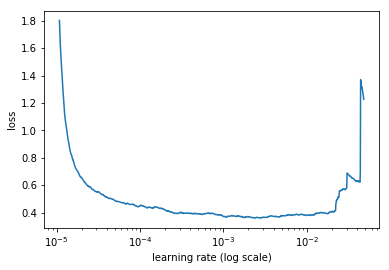

In [55]:
m.sched.plot()

In [56]:
lr=5.0e-5
m.fit(lr, 3, metrics=[exp_rmsle], cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.36065  0.35247  0.59251]                           
[ 1.       0.334    0.32686  0.57049]                           
[ 2.       0.3201   0.32173  0.56601]                           
[ 3.       0.31909  0.32209  0.56627]                           
[ 4.       0.31596  0.31786  0.56258]                           
[ 5.       0.29835  0.31438  0.55947]                           
[ 6.       0.30538  0.31377  0.55894]                           



In [48]:
lr = 5.0e-4
m.fit(lr, 3, metrics=[exp_rmsle], cycle_len=2)

A Jupyter Widget

[ 0.       0.32404  0.31878  0.56345]                           
[ 1.       0.30513  0.31197  0.55732]                           
[ 2.       0.29919  0.31445  0.55954]                           
[ 3.       0.28376  0.31089  0.55636]                           
[ 4.       0.30098  0.3125   0.55779]                           
[ 5.       0.28833  0.31059  0.55608]                           



In [47]:
??md.get_learner